In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')

FOLDERNAME = '/content/drive/MyDrive/IISc/Jan-2023/AIP/Assignments/AIP2023-Assignment1/AIP2023-Assignment1'
assert FOLDERNAME is not None, "[!] Enter the foldername."


Mounted at /content/drive


In [2]:
!pip install split-folders
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import image as mpimg

import os
import shutil
import time
import splitfolders

from pandas.core.common import flatten
import copy
import numpy as np
import random

from PIL import Image

import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler

from torchvision.models.feature_extraction import get_graph_node_names
from torchvision.models.feature_extraction import create_feature_extractor

from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.activation import ReLU

from sklearn.metrics import classification_report

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
##Code to split train data folder into train and val folders
##Please change the input and output folder paths before running this 
##This might take 3-4 mins to run
input_folder = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'train'
output_folder = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'split'
splitfolders.ratio(input_folder, output = output_folder, seed = 1337, ratio = (0.8, 0.2), group_prefix=None, move = False )

Copying files: 532 files [10:28,  1.18s/ files]


In [4]:
##Function to get mean and std of the data
def get_mean_std(dir):
  transform_img = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
        ])
  dataset = torchvision.datasets.ImageFolder(dir, transform_img)
  loader = torch.utils.data.DataLoader(dataset, batch_size=len(dataset), shuffle = False, num_workers=0)

  images, lebels = next(iter(loader))
  # shape of images = [b,c,w,h]
  mean, std = images.mean([0,2,3]), images.std([0,2,3])
  return mean.numpy(), std.numpy()


In [5]:
mean, std = get_mean_std('{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'train')

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

In [7]:
split_dir = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'split'
test_dir = '{}/assignment1_data/classification_dataset/'.format(FOLDERNAME) + 'test'
image_datasets = { x : torchvision.datasets.ImageFolder(os.path.join(split_dir, x), transform=data_transforms[x]) for x in ['train', 'val'] }
image_datasets['test'] = torchvision.datasets.ImageFolder(test_dir, data_transforms['test']) 
shuffle_datasets = {'train': True, 'val': True, 'test': False}
dataloaders = { x : torch.utils.data.DataLoader(image_datasets[x], batch_size = 4, shuffle = shuffle_datasets[x], num_workers = 2) for x in ['train', 'val', 'test'] }

class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [8]:
##Class to define the model
class ConvModel(nn.Module):

  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc1 = nn.Sequential(
        nn.Linear(56*56*64, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    # print(out.shape)
    out = self.layer2(out)
    # print(out.shape)
    out = out.reshape(out.size(0), -1)
    # print(out.shape)
    out = self.fc1(out)

    return out
   

In [9]:
##Function to train the model
def train_model(model, scheduler, dataloaders, criterion, optimizer, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [10]:
##Helper function for model visualization
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [11]:
#Function to visualize the model
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        # model.train(mode=was_training)

In [12]:
##Function to test the model
def test_model(model, dataloader):
  model.eval()
  test_labels = []
  pred_labels = []
  with torch.no_grad():
    running_corrects = 0
    for i, (inputs, labels) in enumerate(dataloaders['test']):
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      
      running_corrects += torch.sum(preds == labels.data)
      test_labels.append(labels.cpu().detach().numpy())
      pred_labels.append(preds.cpu().detach().numpy())

      # pred = preds.cpu().numpy()
      # labels = labels.cpu().numpy()
      # print(preds, labels)

    running_corrects = running_corrects.cpu().numpy()
    test_acc = float(running_corrects) / len(dataloaders['test'].dataset)
    # print(running_corrects)
    # print(len(dataloaders['test'].dataset))
    print("Test Accuracy- ", test_acc)
    test_labels = np.array(test_labels).flatten()
    pred_labels = np.array(pred_labels).flatten()
    report = classification_report(test_labels, pred_labels)
    return report


In [13]:
def cleanup():
  dir = '{}/assignment1_data/classification_dataset/split'.format(FOLDERNAME)
  if os.path.exists(dir):
    shutil.rmtree(dir)

In [14]:
##Code to initialize the model
model = ConvModel(3, 6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [15]:
##Code to print the model (all layers with discription)
print(model)

ConvModel(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=200704, out_features=6, bias=True)
  )
)


In [16]:
##training the model
model = model.to(device)
model = train_model(model, exp_lr_scheduler, dataloaders, criterion, optimizer, num_epochs=25)

Epoch 0/24
----------
train Loss: 25.1209 Acc: 0.1560
val Loss: 1.7702 Acc: 0.2294

Epoch 1/24
----------
train Loss: 1.7826 Acc: 0.2033
val Loss: 1.7938 Acc: 0.2018

Epoch 2/24
----------
train Loss: 1.7884 Acc: 0.1962
val Loss: 1.7858 Acc: 0.1560

Epoch 3/24
----------
train Loss: 1.7882 Acc: 0.2080
val Loss: 1.7823 Acc: 0.2110

Epoch 4/24
----------
train Loss: 1.7855 Acc: 0.2175
val Loss: 1.7797 Acc: 0.2018

Epoch 5/24
----------
train Loss: 1.7777 Acc: 0.2151
val Loss: 1.7713 Acc: 0.2385

Epoch 6/24
----------
train Loss: 1.7663 Acc: 0.2388
val Loss: 1.7624 Acc: 0.2385

Epoch 7/24
----------
train Loss: 1.7646 Acc: 0.2435
val Loss: 1.7682 Acc: 0.2294

Epoch 8/24
----------
train Loss: 1.7503 Acc: 0.2317
val Loss: 1.7623 Acc: 0.2661

Epoch 9/24
----------
train Loss: 1.7959 Acc: 0.1891
val Loss: 1.7746 Acc: 0.2294

Epoch 10/24
----------
train Loss: 1.7597 Acc: 0.2364
val Loss: 1.7690 Acc: 0.2294

Epoch 11/24
----------
train Loss: 1.7705 Acc: 0.2530
val Loss: 1.7671 Acc: 0.2385

E

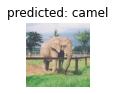

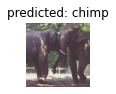

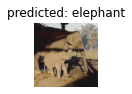

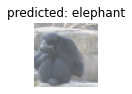

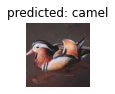

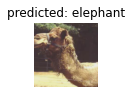

In [17]:
##Visualizing model predictions 
visualize_model(model, 6)

In [18]:
##Testing the model
model = model.to(device)
report = test_model(model, dataloaders)
print(report)

Test Accuracy-  0.225
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.67      0.30      0.41        20
           2       0.24      0.35      0.29        20
           3       0.21      0.15      0.18        20
           4       0.00      0.00      0.00        20
           5       0.16      0.55      0.25        20

    accuracy                           0.23       120
   macro avg       0.21      0.23      0.19       120
weighted avg       0.21      0.23      0.19       120



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Experiments

In [ ]:
def experiment_model(model, scheduler, dataloaders, criterion, optimizer, num_epochs=25):
  train_acc = []
  test_acc = []
  val_acc = []

  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict)     ##state_dict - Python dicionary which maps each layer to its parameter tensor
  best_acc = 0.0

  for epoch in range(num_epochs):
    print(f'Epoch {epoch}/{num_epochs - 1}')
    print('-' * 10)

    for phase in ['test','train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
    
      running_loss = 0.00
      running_corrects = 0.0

      for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()   # zero the parameter gradients at the start of training loop

        with torch.set_grad_enabled(phase == 'train'):

          outputs = model(inputs)
          loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data).detach().cpu().numpy()

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / len(dataloaders[phase].dataset)
      epoch_acc = running_corrects / len(dataloaders[phase].dataset)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
      if phase == 'train':
        train_acc.append(epoch_acc)

      if phase == 'test':
        test_acc.append(epoch_acc)
      
      if phase == 'val':
        val_acc.append(epoch_acc)

      if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          best_model_wts = copy.deepcopy(model.state_dict())


    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return train_acc, test_acc, val_acc


In [ ]:
model = ConvModel(3, 6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.to(device)
train_acc_Relu, test_acc_Relu, val_acc_Relu = experiment_model(model, exp_lr_scheduler, dataloaders, criterion, optimizer, num_epochs=60)

Epoch 0/59
----------
test Loss: 1.7896 Acc: 0.1333
train Loss: 23.7040 Acc: 0.2128
val Loss: 1.8049 Acc: 0.2477

Epoch 1/59
----------
test Loss: 1.7874 Acc: 0.2083
train Loss: 1.7984 Acc: 0.2104
val Loss: 1.7860 Acc: 0.2294

Epoch 2/59
----------
test Loss: 1.7834 Acc: 0.2167
train Loss: 1.7948 Acc: 0.1986
val Loss: 1.7817 Acc: 0.1927

Epoch 3/59
----------
test Loss: 1.7939 Acc: 0.1583
train Loss: 1.7873 Acc: 0.2057
val Loss: 1.7787 Acc: 0.2385

Epoch 4/59
----------
test Loss: 1.7916 Acc: 0.2000
train Loss: 1.7723 Acc: 0.2151
val Loss: 1.7704 Acc: 0.2569

Epoch 5/59
----------
test Loss: 1.7863 Acc: 0.2083
train Loss: 1.7622 Acc: 0.2270
val Loss: 1.7595 Acc: 0.2110

Epoch 6/59
----------
test Loss: 1.7946 Acc: 0.2833
train Loss: 1.7507 Acc: 0.2175
val Loss: 1.7453 Acc: 0.2385

Epoch 7/59
----------
test Loss: 1.7668 Acc: 0.2333
train Loss: 1.7333 Acc: 0.2459
val Loss: 1.7434 Acc: 0.2385

Epoch 8/59
----------
test Loss: 1.7699 Acc: 0.2250
train Loss: 1.7611 Acc: 0.2009
val Loss: 1.

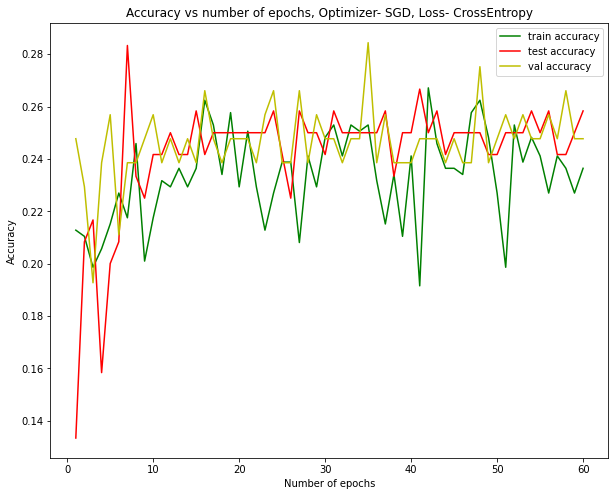

In [ ]:
epoch_num = range(1,61)
plt.figure(figsize=(10,8))
plt.plot(epoch_num, train_acc_Relu, 'g', label = 'train accuracy')
plt.plot(epoch_num, test_acc_Relu, 'r', label = 'test accuracy')
plt.plot(epoch_num, val_acc_Relu, 'y', label = 'val accuracy')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Accuracy vs number of epochs, Optimizer- SGD, Loss- CrossEntropy')
plt.legend()
plt.show()

In [ ]:
##Class to define the model
class ConvModel_inc(nn.Module):

  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer3 = nn.Sequential(
        nn.Conv2d(64, out_channels=128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc1 = nn.Sequential(
        nn.Linear(28*28*128, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    # print(out.shape)
    out = self.layer2(out)
    # print(out.shape)
    out = self.layer3(out)
    out = out.reshape(out.size(0), -1)
    # print(out.shape)
    out = self.fc1(out)

    return out

In [ ]:

model = ConvModel_inc(3, 6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.to(device)
train_acc_Relu_inc, test_acc_Relu_inc, val_acc_Relu_inc = experiment_model(model, exp_lr_scheduler, dataloaders, criterion, optimizer, num_epochs=60)

Epoch 0/59
----------
test Loss: 1.7942 Acc: 0.1917
train Loss: 28.8154 Acc: 0.2151
val Loss: 5.3112 Acc: 0.1468

Epoch 1/59
----------
test Loss: 4.8460 Acc: 0.2333
train Loss: 2.3680 Acc: 0.2222
val Loss: 1.7090 Acc: 0.3119

Epoch 2/59
----------
test Loss: 1.7185 Acc: 0.2583
train Loss: 1.7755 Acc: 0.2813
val Loss: 1.7026 Acc: 0.3578

Epoch 3/59
----------
test Loss: 1.6575 Acc: 0.4083
train Loss: 1.6980 Acc: 0.3026
val Loss: 1.6592 Acc: 0.4037

Epoch 4/59
----------
test Loss: 1.5828 Acc: 0.3833
train Loss: 1.6804 Acc: 0.3499
val Loss: 1.6159 Acc: 0.3578

Epoch 5/59
----------
test Loss: 1.5683 Acc: 0.3917
train Loss: 1.7435 Acc: 0.2813
val Loss: 1.6260 Acc: 0.3670

Epoch 6/59
----------
test Loss: 1.6151 Acc: 0.3917
train Loss: 1.6939 Acc: 0.3073
val Loss: 1.5844 Acc: 0.4128

Epoch 7/59
----------
test Loss: 1.5540 Acc: 0.4333
train Loss: 1.6665 Acc: 0.3333
val Loss: 1.5546 Acc: 0.4037

Epoch 8/59
----------
test Loss: 1.5388 Acc: 0.4833
train Loss: 1.6490 Acc: 0.3191
val Loss: 1.

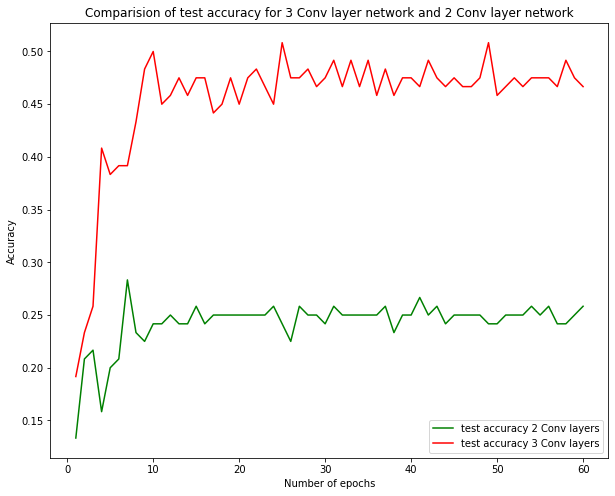

In [ ]:
epoch_num = range(1,61)
plt.figure(figsize=(10,8))
plt.plot(epoch_num, test_acc_Relu, 'g', label = 'test accuracy 2 Conv layers')
plt.plot(epoch_num, test_acc_Relu_inc, 'r', label = 'test accuracy 3 Conv layers')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Comparision of test accuracy for 3 Conv layer network and 2 Conv layer network')
plt.legend()
plt.show()

In [ ]:
##Class to define the model
class ConvModel_leaky(nn.Module):

  def __init__(self, in_channels, num_classes):
    super().__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.layer2 = nn.Sequential(
        nn.Conv2d(32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.01),
        nn.MaxPool2d(kernel_size=2, stride=2))
    self.fc1 = nn.Sequential(
        nn.Linear(56*56*64, num_classes)
    )

  def forward(self, x):
    out = self.layer1(x)
    # print(out.shape)
    out = self.layer2(out)
    # print(out.shape)
    out = out.reshape(out.size(0), -1)
    # print(out.shape)
    out = self.fc1(out)

    return out
   

In [ ]:
model = ConvModel_leaky(3, 6)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
model = model.to(device)
train_acc_leaky, test_acc_leaky, val_acc_leaky = experiment_model(model, exp_lr_scheduler, dataloaders, criterion, optimizer, num_epochs=60)

Epoch 0/59
----------
test Loss: 1.7999 Acc: 0.1833
train Loss: 22.6461 Acc: 0.1797
val Loss: 1.7803 Acc: 0.2294

Epoch 1/59
----------
test Loss: 1.7362 Acc: 0.2750
train Loss: 1.7987 Acc: 0.2104
val Loss: 1.7389 Acc: 0.2569

Epoch 2/59
----------
test Loss: 1.6946 Acc: 0.2917
train Loss: 1.7646 Acc: 0.2151
val Loss: 1.7518 Acc: 0.2661

Epoch 3/59
----------
test Loss: 1.6897 Acc: 0.2833
train Loss: 1.7810 Acc: 0.2246
val Loss: 1.7144 Acc: 0.3211

Epoch 4/59
----------
test Loss: 1.6943 Acc: 0.3083
train Loss: 1.7659 Acc: 0.2388
val Loss: 1.6997 Acc: 0.3028

Epoch 5/59
----------
test Loss: 1.6782 Acc: 0.3167
train Loss: 1.7463 Acc: 0.2671
val Loss: 1.6939 Acc: 0.3119

Epoch 6/59
----------
test Loss: 1.6646 Acc: 0.3083
train Loss: 1.7373 Acc: 0.2648
val Loss: 1.7063 Acc: 0.3028

Epoch 7/59
----------
test Loss: 1.6508 Acc: 0.3500
train Loss: 1.7175 Acc: 0.2600
val Loss: 1.7063 Acc: 0.3028

Epoch 8/59
----------
test Loss: 1.6393 Acc: 0.3500
train Loss: 1.7218 Acc: 0.2813
val Loss: 1.

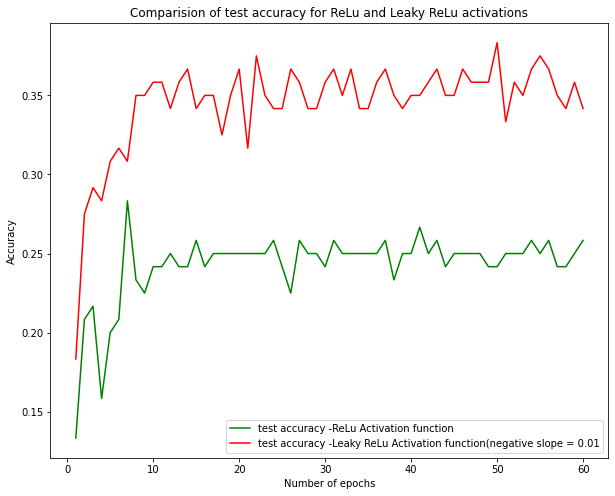

In [ ]:
epoch_num = range(1,61)
plt.figure(figsize=(10,8))
plt.plot(epoch_num, test_acc_Relu, 'g', label = 'test accuracy -ReLu Activation function')
plt.plot(epoch_num, test_acc_leaky, 'r', label = 'test accuracy -Leaky ReLu Activation function(negative slope = 0.01')
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.title('Comparision of test accuracy for ReLu and Leaky ReLu activations')
plt.legend()
plt.show()

In [ ]:
cleanup()